In [90]:
# stock imports
import numpy as np
import pandas as pd
import json
import scipy
import random


##plotting
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import corner
from cmcrameri import cm

from scripts import prior_funcs, utils

from functools import partial

# plt.style.use('dark_background')
plt.style.use("Solarize_Light2")
plt.rcParams.update({"axes.edgecolor": "black"})
plt.rcParams.update({"text.color": "black"})
plt.rcParams.update({"axes.labelcolor": "black"})
plt.rcParams.update({"xtick.color": "black"})
plt.rcParams.update({"ytick.color": "black"})
plt.rcParams.update({"font.family": "monospace"})

# tinygp
import tinygp

In [91]:
df_full = pd.concat(
    [
        pd.read_hdf(
            "/home/oxs235/datastorage/repos_data/ojscutt/mesa_ajl/data/grid2p5a/grid.h5",
            key=f"m{0.8 + i*0.02:.2f}",
        )
        for i in range(21)
    ],
    ignore_index=True,
)
df = df_full[df_full["log_g"] >= 3.6]
df = df[df["star_age"] <= 14]
df = df[df["frac_age"] >= 0.015]

inputs = ["initial_mass", "initial_Zinit", "initial_Yinit", "initial_MLT", "star_age"]
outputs = (
    ["radius", "luminosity", "star_feh"]
    + [f"nu_0_{i}" for i in range(6, 41)]
    + ["nu_max"]
)

df = df.loc[(df[[f"nu_0_{i}" for i in range(6, 41)]] != 0).all(axis=1)]

cols = inputs + outputs

df = df[cols]

df.dropna(inplace=True)

df["calc_effective_T"] = utils.calc_Teff(df["luminosity"], df["radius"])
df.describe()

,initial_mass,initial_Zinit,initial_Yinit,initial_MLT,star_age,radius,luminosity,star_feh,nu_0_6,nu_0_7,...,nu_0_33,nu_0_34,nu_0_35,nu_0_36,nu_0_37,nu_0_38,nu_0_39,nu_0_40,nu_max,calc_effective_T
count,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,...,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06
mean,1.021885e+00,1.440698e-02,2.814693e-01,2.117984e+00,5.000177e+00,1.312728e+00,2.116482e+00,-1.127145e-01,7.726572e+02,8.860424e+02,...,3.696535e+03,3.802234e+03,3.907317e+03,4.011806e+03,4.115788e+03,4.219425e+03,4.322952e+03,4.426627e+03,2.370506e+03,5.866797e+03
std,1.175610e-01,9.677123e-03,2.805593e-02,2.879175e-01,3.405371e+00,4.813547e-01,1.572419e+00,3.499532e-01,2.959808e+02,3.426600e+02,...,1.451591e+03,1.494205e+03,1.536228e+03,1.577500e+03,1.617908e+03,1.657417e+03,1.696104e+03,1.734156e+03,1.156533e+03,5.670330e+02
min,8.000000e-01,3.869061e-03,2.400000e-01,1.700000e+00,2.966411e-02,6.990236e-01,1.321735e-01,-1.077903e+00,2.103102e+02,2.385545e+02,...,1.002125e+03,1.032723e+03,1.063221e+03,1.093511e+03,1.123625e+03,1.153506e+03,1.183191e+03,1.212653e+03,4.317504e+02,4.096930e+03
25%,9.200000e-01,6.471429e-03,2.600000e-01,1.900000e+00,2.309880e+00,9.719693e-01,9.371542e-01,-4.000000e-01,5.476978e+02,6.234189e+02,...,2.578850e+03,2.649156e+03,2.720741e+03,2.793748e+03,2.868279e+03,2.944027e+03,3.020312e+03,3.097018e+03,1.444480e+03,5.491841e+03
50%,1.040000e+00,1.077191e-02,2.800000e-01,2.100000e+00,4.275231e+00,1.160016e+00,1.698469e+00,-1.000000e-01,7.832912e+02,8.972267e+02,...,3.760636e+03,3.866328e+03,3.970106e+03,4.072429e+03,4.174203e+03,4.276548e+03,4.380549e+03,4.486487e+03,2.352665e+03,5.859776e+03
75%,1.120000e+00,2.007835e-02,3.000000e-01,2.300000e+00,7.159688e+00,1.498369e+00,2.883064e+00,1.837200e-01,9.935144e+02,1.142381e+03,...,4.784137e+03,4.922458e+03,5.059497e+03,5.194580e+03,5.327444e+03,5.458355e+03,5.587658e+03,5.716681e+03,3.185873e+03,6.219454e+03
max,1.200000e+00,3.897971e-02,3.200000e-01,2.500000e+00,1.399997e+01,2.873431e+00,1.163902e+01,5.094573e-01,1.480807e+03,1.705344e+03,...,7.145063e+03,7.354126e+03,7.562945e+03,7.771521e+03,7.979340e+03,8.185512e+03,8.382538e+03,8.584072e+03,5.856447e+03,7.993034e+03


## randomly sample a and b for each hare

In [92]:
a_vals = -5 # np.random.uniform(-10,2,len(df))
b_vals = 5 # np.random.uniform(4.4,5.25,len(df))

gp_df = df[[f"nu_0_{i}" for i in range(6, 41)] + ["nu_max"]]

gp_df.insert(len(gp_df.columns), 'a',a_vals)
gp_df.insert(len(gp_df.columns), 'b',b_vals)

In [93]:
def surf_corr(freqs, nu_max, a, b):
    return freqs + a * ((freqs / nu_max) ** b)

freq_cols = [f"nu_0_{i}" for i in range(6, 41)]


corr_array = surf_corr(gp_df[freq_cols].values, gp_df['nu_max'].values[:, np.newaxis] , gp_df['a'].values[:, np.newaxis] , gp_df['b'].values[:, np.newaxis])
corr_df = pd.DataFrame(corr_array, columns=[f"nu_0_{i}_corr" for i in range(6, 41)])

In [94]:
corr_df.iloc[0]

nu_0_6_corr     1425.016676
nu_0_7_corr     1640.770193
nu_0_8_corr     1856.636713
nu_0_9_corr     2068.518334
nu_0_10_corr    2278.110485
nu_0_11_corr    2483.612474
nu_0_12_corr    2685.465500
nu_0_13_corr    2886.091007
nu_0_14_corr    3085.575544
nu_0_15_corr    3285.200476
nu_0_16_corr    3483.645425
nu_0_17_corr    3681.006712
nu_0_18_corr    3878.151687
nu_0_19_corr    4075.101855
nu_0_20_corr    4272.846089
nu_0_21_corr    4470.767668
nu_0_22_corr    4668.764867
nu_0_23_corr    4867.043115
nu_0_24_corr    5065.292332
nu_0_25_corr    5263.965553
nu_0_26_corr    5462.780561
nu_0_27_corr    5661.822692
nu_0_28_corr    5861.016139
nu_0_29_corr    6060.018181
nu_0_30_corr    6259.170097
nu_0_31_corr    6457.957577
nu_0_32_corr    6656.658275
nu_0_33_corr    6854.893316
nu_0_34_corr    7052.686419
nu_0_35_corr    7249.843576
nu_0_36_corr    7446.051997
nu_0_37_corr    7640.849735
nu_0_38_corr    7831.691432
nu_0_39_corr    8016.556564
nu_0_40_corr    8202.995373
Name: 0, dtype: floa

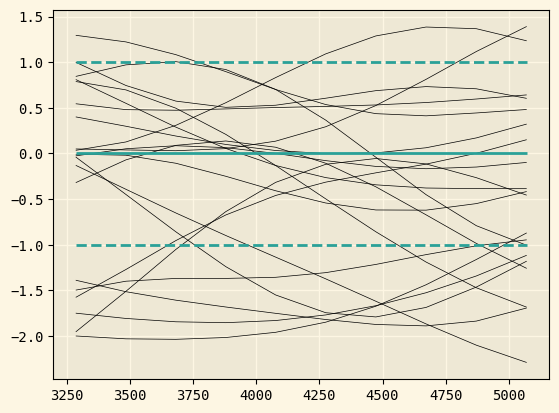

In [113]:
import jax

jax.config.update("jax_enable_x64", True)

from tinygp import GaussianProcess
from tinygp import kernels

def surf_corr(freqs, nu_max, a, b):
    return a * ((freqs / nu_max) ** b)

def mean_function(params, X):
    return X + params['a'] * ((X / params['nu_max']) ** params['b'])

mean_params = {
    "a": -5,
    "b": 5,
    "nu_max": gp_df['nu_max'].iloc[0],
}

# Simulate a made up dataset, as an example
X = gp_df[[f"nu_0_{i}" for i in range(15, 25)]].iloc[0].values.flatten()

#X = np.linspace(X.min(), X.max(), 1000)

# Compute the log probability
kernel = 1*kernels.ExpSquared(scale=5*np.mean(X[1:]-X[:-1]))
gp = GaussianProcess(kernel, X, diag=1e-9)

samples = 20

y_func = gp.sample(jax.random.PRNGKey(1), shape=(samples,))

plt.plot(X, y_func.T, color="k", lw=0.5)


mu = gp.mean
std = np.sqrt(gp.variance)
plt.plot(X, mu, "C1", label="mean")
plt.plot(X, mu + std, "--C1", label="1-sigma region")
plt.plot(X, mu - std, "--C1")


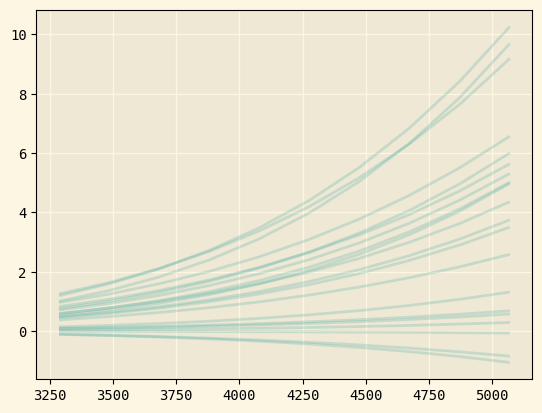

In [114]:
plt.plot(np.tile(X,(samples,1)).T, -surf_corr(np.tile(X,(samples,1)).T,gp_df['nu_max'].iloc[0], np.random.uniform(-10,2,samples), np.random.uniform(4.4,5.25,samples)), c='C1', alpha=0.2);
#plt.xlim([1300, 4500])
#plt.ylim([-5,5])

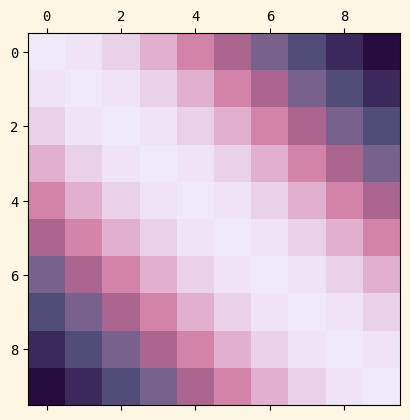

In [115]:
corr = tinygp.solvers.DirectSolver(kernel, X, noise=tinygp.noise.Dense(value=np.zeros((len(X),len(X))))).covariance()
plt.matshow(corr, cmap=cm.acton)
plt.grid(visible=None)

In [112]:
corr

Array([[1.00000000e+00, 9.77239868e-01, 9.11974232e-01, ...,
        1.13482944e-09, 3.29713759e-10, 9.10147076e-11],
       [9.77239868e-01, 1.00000000e+00, 9.77214958e-01, ...,
        4.39605141e-09, 1.33031564e-09, 3.82668483e-10],
       [9.11974232e-01, 9.77214958e-01, 1.00000000e+00, ...,
        1.62744446e-08, 5.12971637e-09, 1.53767568e-09],
       ...,
       [1.13482944e-09, 4.39605141e-09, 1.62744446e-08, ...,
        1.00000000e+00, 9.82154239e-01, 9.29714787e-01],
       [3.29713759e-10, 1.33031564e-09, 5.12971637e-09, ...,
        9.82154239e-01, 1.00000000e+00, 9.81735810e-01],
       [9.10147076e-11, 3.82668483e-10, 1.53767568e-09, ...,
        9.29714787e-01, 9.81735810e-01, 1.00000000e+00]], dtype=float64)